<a href="https://colab.research.google.com/github/megan0422/DABPFinalProject/blob/main/Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization model 

##The goal of this document is to:
##1. Prepare a cost prediction model and predict the cost of the bridges that have missing cost data
##2. Prepare data to run the bridge budget opimization model
##3. Run the bridge budget opimization model
##4. Conduct sensitivity analysis

## 1. Prepare a cost prediction model and predict the cost of the bridges whose cost is missing using the model

74 out of 172 data of the bridge managed by Allegheny County in NBI dataset don't have cost data (TOTAL_IMP_COST_096). Therefore, we build the cost prediction model to impute the missing values using classification model we built so far.

In [104]:
# import packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import accuracy_score
from random import randrange
import warnings
import math
from sklearn import tree
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split #from imblearn import under_sampling, over_sampling
!pip install gurobipy
import gurobipy as gp
from gurobipy import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [105]:
#Loading PA bridge dataset and filtering out bridges outside of Allegheny County
# NBI data
url = 'https://raw.githubusercontent.com/megan0422/DABPFinalProject/main/PA22.csv'
PA22 = pd.read_csv(url)
PA22_allegheny = PA22[PA22["COUNTY_CODE_003"] == 3]

In [106]:
#Variables most relevant to bridge condition prediction
relevant_variables_plus_alpha = ['PLACE_CODE_004', 'TOLL_020', 'MAINTENANCE_021',  'FUNCTIONAL_CLASS_026', 
                     'YEAR_BUILT_027', 'TRAFFIC_LANES_ON_028A' , 'ADT_029', 'DEGREES_SKEW_034',
                      'STRUCTURE_KIND_043A', 'STRUCTURE_TYPE_043B', 'MAIN_UNIT_SPANS_045', 
                      'MAX_SPAN_LEN_MT_048', 'STRUCTURE_LEN_MT_049', 'ROADWAY_WIDTH_MT_051', 
                      'CHANNEL_COND_061', 'DATE_OF_INSPECT_090', 'INSPECT_FREQ_MONTHS_091',
                      'HIGHWAY_SYSTEM_104', 'HIGHWAY_SYSTEM_104', 'DECK_STRUCTURE_TYPE_107', 
                      'SURFACE_TYPE_108A', 'MEMBRANE_TYPE_108B', 'DECK_PROTECTION_108C', 
                      'PERCENT_ADT_TRUCK_109', 'BRIDGE_CONDITION', 'DECK_AREA','TOTAL_IMP_COST_096','STRUCTURE_NUMBER_008']

#Creating a bridge dataset of variables for 'bridge-alone' classification models
Bridges_class = PA22_allegheny[PA22_allegheny.columns.intersection(relevant_variables_plus_alpha)]


In [107]:
#Creates new column based on data dictionarys 

#TOLL_020 
Toll = {1:1, 2:1, 3:1, 4:1, 5:1}  
#MAINTENANCE_021 
#Note that more than one agency can share the responsibility of bridge maintenance, in these cases the agency 
#with the highest hieracrchy within that responsibility is listed (e.g. if both municipal and state share 
#responsibilities state will be listed). #According to the output in the chunk above, none of the bridges 
#in AC have a maintenace code above 31. For our purposes, highway and toll authority are grouped together 

Maintenance = {1: 'State', 2: 'County', 3: 'Municipal', 4: 'Municipal', 11: 'State', 12: 'Municipal', 
               21: 'State', 25: 'Municipal', 26: 'Private', 27: 'Railroad', 31: 'State', 
               32: 'Municipal'}

#FUNCTIONAL_CLASS_026
#Creating Urban category based on the FUNCTIONAL_CLASS data dictionary
Urban = {1:0,2:0,6:0,7:0,8:0,9:0,11:1,12:1,14:1,16:1,17:1,19:1}

#FUNCTIONAL_CLASS_026
Function = {1: 'Interstate Principal Arterial', 2: 'Other Principal Arterial', 6: 'Minor Arterial', 
            7: 'Major Collector', 8: 'Minor Collector', 9: 'Municipal', 11: 'Interstate Principal Arterial', 
            12: 'Other Principal Arterial Freeways', 14: 'Other Principal Arterial', 16: 'Minor Arterial',
            17: 'Collector', 19: 'Municipal'}

#STRUCTURE_KIND_043A
Structure_Kind = {1: 'Concrete', 2: 'Concrete continuous', 3: 'Steel', 4: 'Steel continuous', 5: 'Prestressed concrete', 
                  6: 'Prestressed concrete continuous', 7: 'Wood', 8: 'Masonary', 9: 'Aluminum', 0: 'Other'}

#STRUCTURE_TYPE_043B
Structure_Type = {1: 'Slab', 2: 'Stringer or Girder', 3: 'Girder and floorbeam', 4: 'Tee beam', 
                  5: 'Multiple box beams or girders', 6: 'Single box beam or girder', 7: 'Frame', 
                  8: 'Orthotropic', 9: 'Truss - Deck', 10: 'Truss - Thru', 11: 'Arch - Deck',
                  12: 'Arch - Thru', 13: 'Suspension', 14: 'Stayed Girder', 15: 'Movable - Lift',
                  16: 'Movable - Bascule', 17: 'Movable - Swing', 18: 'Tunnel', 19: 'Culvert',
                  20: 'Mixed types', 21: 'Segmental Box Girder', 22: 'Channel Beam', 0: 'Other'}

#DECK_STRUCTURE_TYPE_107
Deck = {'N': 0, '1': 1, '2': 1, '3': 1, '4': 1, '5':1, '6': 1, '7': 1, '8': 1, '9': 1}

Deck_Structure = {'N': 'No deck', '1': 'Concrete Cast-in-Place', '2': 'Concrete Precast Panels', 
                  '3': 'Open Grating', '4': 'Closed Grating', '5': 'Steel plate', '6': 'Corrugated Steel', 
                  '7': 'Aluminum', '8': 'Wood', '9': 'Other'}

#SURFACE_TYPE_108A
Surface_Type = {'N': 'No deck', '0': 'None', '1': 'Monolithic Concrete', '2': ' Integral Concrete', '3': 'Latex Concrete', 
                '4': 'Low Slump Concrete', '5': 'Epoxy Overlay', '6': 'Bituminous', '7': 'Wood', 
                '8': 'Gravel', '9': 'Other'}

#MEMBRANE_TYPE_108B
Membrane_Type = {'N': 'No deck','0': 'None', '1': 'Built-up', '2': 'Preformed Fabric', '3': 'Epoxy', '8': 'Unknown',
                 '9': 'Other'}

#DECK_PROTECTION_108C
Deck_Protect = {'N': 'No deck','0': 'None', '1': 'Epoxy Coated', '2': 'Galvanized', '3': 'Other Coated Reinforcing', 
                '4': 'Cathodic Protection', '6': 'Polymer Impregnated', '7': 'Internally Sealed', 
                '8': 'Unknown', '9': 'Other', }

In [108]:
#Using dictionaries to create new columns that are easier to interpret for the reader
new_variables = [ 'Age', 'Toll','Urban','Maintenance', 'Function', 'Structure_Kind', 'Structure_Type', 
                 'Deck_Structure', 'Surface_Type', 'Membrane_Type', 'Deck_Protect', 'Deck']

Bridges_class['Toll'] = Bridges_class['TOLL_020'].map(Toll)
Bridges_class['Maintenance'] = Bridges_class['MAINTENANCE_021'].map(Maintenance)
Bridges_class['Urban'] = Bridges_class['FUNCTIONAL_CLASS_026'].map(Urban)
Bridges_class['Function'] = Bridges_class['FUNCTIONAL_CLASS_026'].map(Function)
Bridges_class['Structure_Kind'] = Bridges_class['STRUCTURE_KIND_043A'].map(Structure_Kind)
Bridges_class['Structure_Type'] = Bridges_class['STRUCTURE_TYPE_043B'].map(Structure_Type)
Bridges_class['Deck_Structure'] = Bridges_class['DECK_STRUCTURE_TYPE_107'].map(Deck_Structure)
Bridges_class['Deck'] = Bridges_class['DECK_STRUCTURE_TYPE_107'].map(Deck)
Bridges_class['Surface_Type'] = Bridges_class['SURFACE_TYPE_108A'].map(Surface_Type)
Bridges_class['Membrane_Type'] = Bridges_class['MEMBRANE_TYPE_108B'].map(Membrane_Type)
Bridges_class['Deck_Protect'] = Bridges_class['DECK_PROTECTION_108C'].map(Deck_Protect)
Bridges_class['Age'] = 2022 - Bridges_class['YEAR_BUILT_027']

In [109]:
#convert DATE_OF_INSPECT_090_test to datetime object
Bridges_class['DATE_OF_INSPECT_090']=pd.to_datetime(Bridges_class['DATE_OF_INSPECT_090'], format='%m%y')                                                      

In [110]:
#Change new categorical variable into category data type 
category_vars = ['Maintenance', 'Function', 'Structure_Kind', 'Structure_Type', 'Deck_Structure', 'Surface_Type', 
                'Membrane_Type', 'Deck_Protect'] 
#Values need to be 'category' dtype to make dummy variables

for var in category_vars:
     Bridges_class[var] = Bridges_class[var].astype('category')

In [111]:
#List of all variables that will be considered for classification. See report.  
all_variables = new_variables + ['PLACE_CODE_004','TRAFFIC_LANES_ON_028A' , 'ADT_029', 'DEGREES_SKEW_034', 
                                 'MAX_SPAN_LEN_MT_048', 'STRUCTURE_LEN_MT_049', 'ROADWAY_WIDTH_MT_051', 
                                 'MAIN_UNIT_SPANS_045','INSPECT_FREQ_MONTHS_091','HIGHWAY_SYSTEM_104', 
                                 'PERCENT_ADT_TRUCK_109', 'BRIDGE_CONDITION', 'DECK_AREA','TOTAL_IMP_COST_096','STRUCTURE_NUMBER_008'] 

                                    
Bridges_class_v2 = Bridges_class[Bridges_class.columns.intersection(all_variables)]
Bridges_class_v2.head()
#MAX_SPAN_LEN_MT_048, STRUCTURE_LEN_MT_049, ROADWAY_WIDTH_MT_051 and others need to be transformed because last digit is a tenth
# For example Length of Maximum Span 35.5 meters 00355

STRUCTURE_NUMBER_008  PLACE_CODE_004  TRAFFIC_LANES_ON_028A  ADT_029  \
182                  488           61000                      4    13887   
183                  491           24160                      2    16758   
184                  492           24160                      1    16107   
185                  495           69584                      4    32865   
186                  496           69584                      4    32865   

     DEGREES_SKEW_034  MAIN_UNIT_SPANS_045  MAX_SPAN_LEN_MT_048  \
182                99                    4                121.9   
183                99                   11                 26.8   
184                99                   11                 25.9   
185                45                    1                 21.0   
186                 5                    1                 20.4   

     STRUCTURE_LEN_MT_049  ROADWAY_WIDTH_MT_051  INSPECT_FREQ_MONTHS_091  ...  \
182                 641.9                  15.2                       24  ...   
183                 235.3                   6.0                       24  ...   
184                 212.8                   6.4                       24  ...   
185                  33.8                  15.3                       24  ...   
186                  20.4                  17.5                       24  ...   

     Urban                  Function    Structure_Kind      Structure_Type  \
182      1  Other Principal Arterial  Steel continuous        Truss - Deck   
183      1  Other Principal Arterial             Steel  Stringer or Girder   
184      1  Other Principal Arterial             Steel  Stringer or Girder   
185      1  Other Principal Arterial          Concrete         Arch - Deck   
186      1  Other Principal Arterial          Concrete         Arch - Deck   

             Deck_Structure  Deck         Surface_Type  Membrane_Type  \
182  Concrete Cast-in-Place     1  Monolithic Concrete           None   
183  Concrete Cast-in-Place     1  Monolithic Concrete           None   
184  Concrete Cast-in-Place     1  Monolithic Concrete           None   
185                 No deck     0              No deck        No deck   
186                 No deck     0              No deck        No deck   

     Deck_Protect Age  
182  Epoxy Coated  62  
183  Epoxy Coated  62  
184  Epoxy Coated  62  
185       No deck  97  
186       No deck  97  

[5 rows x 27 columns]

In [112]:
#All continuous variables have to be normalized: ADT_029, DEGREES_SKEW_034,MAIN_UNIT_SPANS_045, MAX_SPAN_LEN_MT_048,
#ROADWAY_WIDTH_MT_051, etc
continous_var = ['Age','ADT_029', 'DEGREES_SKEW_034', 'TRAFFIC_LANES_ON_028A', 'MAIN_UNIT_SPANS_045', 
                 'MAX_SPAN_LEN_MT_048', 'ROADWAY_WIDTH_MT_051', 'STRUCTURE_LEN_MT_049', 'DECK_AREA', 
                 'INSPECT_FREQ_MONTHS_091', 'PERCENT_ADT_TRUCK_109']

def normalize(df, features):
    for feature_name in features:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        df[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return df

Bridges_class_norm = normalize(Bridges_class_v2, continous_var)


In [113]:
dummy_vars = ['Maintenance', 'Function', 'Structure_Kind', 'Structure_Type', 'Deck_Structure', 
              'Surface_Type', 'Membrane_Type', 'Deck_Protect']
drop_columns = ['PLACE_CODE_004']
def prep_bridge_class_norm(df, dummy_vars, drop_columns):
    df = df.drop(columns = drop_columns) 
    result = {'P':0, 'F':1, 'G':1}  #Poor bridges are 0, fair and good are 1, found models are more accurate 
    df['BRIDGE_CONDITION'] = df['BRIDGE_CONDITION'].astype('string')
    df['BRIDGE_CONDITION'] = df['BRIDGE_CONDITION'].map(result)
    df['BRIDGE_CONDITION'] = df['BRIDGE_CONDITION'].astype('uint8')
    df['PERCENT_ADT_TRUCK_109'] = df['PERCENT_ADT_TRUCK_109'].fillna(0) #missing percent average dailt traffic truck is 0
    all_variables = list(df.columns)
    other_vars = [x for x in all_variables if x not in dummy_vars]
    df2 = pd.get_dummies(df[dummy_vars])
    df3 = pd.concat([df[other_vars], df2], axis=1) #concatenates continous variables with dummy variables
    return df3

In [114]:
# combine the normalized dataset with other variables
df = prep_bridge_class_norm(Bridges_class_norm, dummy_vars, drop_columns)

In [115]:
# Extract the data from the bridges managed by allegheny county
df2=df[df['Maintenance_County']==1]

In [116]:
# drop the bridges that have no cost data
df2_cost_NA=df2[df2['TOTAL_IMP_COST_096'].isna()]

In [117]:
# replace NA cost data with 0
df2_cost_0=df2[df2['TOTAL_IMP_COST_096']==0]

In [118]:
# separate 'STRUCTURE_NUMBER_008' column from dataset that does not have cost data for imputation
df_without_cost=df2_cost_NA.append(df2_cost_0, ignore_index=True)
STRUCTURE_NUMBER_without_cost = df_without_cost.loc[:,'STRUCTURE_NUMBER_008']
df_without_cost = df_without_cost.drop(columns = 'STRUCTURE_NUMBER_008')

In [119]:
# make dataset that has cost data
df_with_cost= df2[df2['TOTAL_IMP_COST_096']> 0]

In [120]:
# separate 'STRUCTURE_NUMBER_008' column from dataset that has cost data for the classification model
STRUCTURE_NUMBER_with_cost = df_with_cost.loc[:,'STRUCTURE_NUMBER_008']
df_with_cost = df_with_cost.drop(columns = 'STRUCTURE_NUMBER_008')

In [121]:
# split dataset that has cost data into training data and test data
from sklearn.model_selection import train_test_split
y = df_with_cost.loc[:, df_with_cost.columns =='TOTAL_IMP_COST_096']
X = df_with_cost.loc[:, df_with_cost.columns!= 'TOTAL_IMP_COST_096']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [122]:
# construct the clasiffication model and check the performance
# construct the clasiffication model
tree1 = DecisionTreeRegressor(max_depth=8, random_state=0)
tree1.fit(X_train, y_train)
t3 = tree1.score(X_train, y_train)
t4 = tree1.score(X_test, y_test)

# check the performance
print("R² of Decision Tree Regressor on training set: {:.3f}".format(t3))
print("R² of Decision Tree Regressor on test set: {:.3f}".format(t4))

R² of Decision Tree Regressor on training set: 1.000
R² of Decision Tree Regressor on test set: 0.932


In [123]:
# pick up the column 'TOTAL_IMP_COST_096' from the dataset of the bridges that have no cost information
X2 = df_without_cost.drop(columns = 'TOTAL_IMP_COST_096')

In [124]:
# predict the cost with the classfication model and add them to the dataset
New_cost= tree1.predict(X2)
New_cost=pd.Series(New_cost)

In [125]:
# replace missing cost data with the predicted cost data
df_without_cost['TOTAL_IMP_COST_096']=New_cost
# merging the dataset of the bridges with cost with the dataset of the bridges without cost
df_with_cost_for_all=df_without_cost.append(df_with_cost, ignore_index=True)

In [126]:
# make STRUCTURE_NUMBER dataset to merge the old dataset with the new dataset that has the predicted values of cost
STRUCTURE_NUMBER = pd.concat([STRUCTURE_NUMBER_without_cost,STRUCTURE_NUMBER_with_cost], axis=0)
STRUCTURE_NUMBER_reset = STRUCTURE_NUMBER.reset_index(drop=True)
df_with_cost_for_all = pd.concat([STRUCTURE_NUMBER_reset,df_with_cost_for_all], axis=1)
df_with_cost_merge = df_with_cost_for_all.loc[:, ["STRUCTURE_NUMBER_008", "TOTAL_IMP_COST_096"]]

In [127]:
# extract data on bridges maintained by allegheny county from the whole dataset
PA22_allegheny  = PA22_allegheny[PA22_allegheny["MAINTENANCE_021"] == 2]
# merging 
PA22_allegheny = pd.merge(PA22_allegheny,df_with_cost_merge, on ="STRUCTURE_NUMBER_008")

##2. Prepare data to run the bridge budget opimization model

We pick up the columns to construct the budget optimization model.

In [128]:
# pick up the columns to construct the budget optimization model
PA22_allegheny = PA22_allegheny[["STRUCTURE_NUMBER_008","DETOUR_KILOS_019","ADT_029","STRUCTURE_LEN_MT_049","TOTAL_IMP_COST_096_y","HIGHWAY_SYSTEM_104","PERCENT_ADT_TRUCK_109","BRIDGE_CONDITION"]]

# set up the dummy variable to indicate which bridge has poor condition
PA22_allegheny_cost_dummy = pd.get_dummies(PA22_allegheny,columns=["BRIDGE_CONDITION"])
PA22_allegheny_cost_dummy['Count'] = 1

##3. Run the bridge budget opimization model

Construct the budget optimization model and run the model with Gurobi.

In [129]:
i = len(PA22_allegheny_cost_dummy)
bridge = range(i)

# Step 0. Set up the model
model = Model()

# Step 1. Set up the decision variable and the other variables necessary for constructing the objective function
x = model.addVars(bridge, vtype=GRB.BINARY) # set up the decision variable

#set up the other variables
addtr = (PA22_allegheny_cost_dummy["PERCENT_ADT_TRUCK_109"].to_numpy())/100
adt = PA22_allegheny_cost_dummy["ADT_029"].to_numpy()
hwy = PA22_allegheny_cost_dummy["HIGHWAY_SYSTEM_104"].to_numpy()
bl = PA22_allegheny_cost_dummy["STRUCTURE_LEN_MT_049"].to_numpy()
drt = PA22_allegheny_cost_dummy["DETOUR_KILOS_019"].to_numpy()*1000

#Step 2. Set up the objective function
T = (addtr*adt/24*32*1 + addtr*adt/24*16.2*1.67)*24*365*(drt-bl)
V = (addtr*adt/24*bl*hwy*50*(3.02+0.94) +addtr*adt/24*bl*(1-hwy)*25*(3.02+0.45)+(1-addtr)*adt/24*bl*hwy*50*(3.02+0.45) +(1-addtr)*adt/24*bl*(1-hwy)*25*(3.02+0.45))*24*365*(drt-bl)
model.setObjective (sum((T[i]+V[i])*x[i] for i in bridge))
model.modelSense = GRB.MAXIMIZE

#Step 3. Set up the constraints
# To build cost constraint and safety constraint, set the variables to indicate the cost / the bridge condition(which bridge has poor condition)
C = PA22_allegheny_cost_dummy["TOTAL_IMP_COST_096_y"].to_numpy()*1000
B = 37900000
dummy_p = PA22_allegheny_cost_dummy["BRIDGE_CONDITION_P"].to_numpy()
count_var = PA22_allegheny_cost_dummy['Count'].to_numpy()

model.addConstr(sum(C[i]*x[i] for i in bridge) <= B) #budget constraint
model.addConstr(sum(dummy_p[i]*x[i] for i in bridge) >= (sum(count_var[i]*x[i] for i in bridge))/2) #safety constraint

#Step 4. optimize 
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 2 rows, 172 columns and 344 nonzeros
Model fingerprint: 0xbc5d3a23
Variable types: 0 continuous, 172 integer (172 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+08]
  Objective range  [5e+10, 2e+16]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+07, 4e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 1.428035e+15
Presolve removed 0 rows and 2 columns
Presolve time: 0.00s
Presolved: 2 rows, 170 columns, 340 nonzeros
Variable types: 0 continuous, 170 integer (170 binary)
Found heuristic solution: objective 3.376737e+16

Root relaxation: objective 4.950976e+16, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node 

In [130]:
# count how many bridges are selected and find out the STRUCTURE NUMBER of the bridges selected
decision_variable = []
for v in model.getVars():
    decision_variable.append(v.x)
structure_number_with_zero = np.array(decision_variable)*PA22_allegheny_cost_dummy["STRUCTURE_NUMBER_008"].to_numpy().astype(int) 
structure_number = structure_number_with_zero[structure_number_with_zero != 0] 
bridge_number = len(structure_number) 
print(bridge_number, "bridges should be repair/replacement") 
print("The STRUCTURE NUMBER of the bridges to repair/replace are",structure_number) 

12 bridges should be repair/replacement
The STRUCTURE NUMBER of the bridges to repair/replace are [1310. 2179. 2192. 2202. 2232. 2503. 2574. 2579. 2580. 2632. 2666. 2721.]


In [131]:
# list the name of the bridges selected
list_selected = PA22.query('STRUCTURE_NUMBER_008 == ["1310","2179","2192","2202","2232","2503","2574","2579","2580","2632","2721"]')
bridge_name = list_selected[["LOCATION_009"]]
bridge_name

LOCATION_009
496      MA08   GLENWOOD BRIDGE'
803   PU02   PLUM CRK U BR NO 2'
806     CM06 .2 MI E/KEINERS LN'
808      PD03   JACKS RUN NO. 3'
824    PS06   PINE CR S.BR.  #6'
974   MA12   HOMESTEAD HIGH LEV'
1004  OB02   CORAOPOLIS-NEV ISL'
1007  MA14   MANSFIELD-DRAVOSBG'
1008  MA26   MAPLE AV UNDERPASS'
1044     AB04 ABERS CREEK NO. 4'
1084      LG03   LONG RUN NO. 3'

##4. Conduct sensitivity analysis

Conduct the sensitivity analysis with different budgets by iterating the model depending on the different budgets and plot the result.

In [132]:
i = len(PA22_allegheny_cost_dummy)
bridge = range(i)
list_objective_x = [] # set up the empty list 

# set the budget range for sensitivity analysis
# restore the different budgets in the empty list to iterate the model
budget_range = range(0, 70000000, 1000000)
for n in budget_range:
  list_objective_x.append(n)

list_objective_y = [] # set up the list to restore how much benefit the County gets depending the different budgets
counter = [] 
counter_list =[]

# set loop to iterate the model with different budgets
for B in budget_range:
  # Step 0. Set up the model
  model = Model()

  # Step 1. Set up the decision variable and the variables necessary for constructing the objective function
  x = model.addVars(bridge, vtype=GRB.BINARY) #set up the decision variables

  #set up the other variables
  addtr = (PA22_allegheny_cost_dummy["PERCENT_ADT_TRUCK_109"].to_numpy())/100
  adt = PA22_allegheny_cost_dummy["ADT_029"].to_numpy()
  hwy = PA22_allegheny_cost_dummy["HIGHWAY_SYSTEM_104"].to_numpy()
  bl = PA22_allegheny_cost_dummy["STRUCTURE_LEN_MT_049"].to_numpy()
  drt = PA22_allegheny_cost_dummy["DETOUR_KILOS_019"].to_numpy()*1000

  #Step 2. Set up the objective function
  T = (addtr*adt/24*32*1 + addtr*adt/24*16.2*1.67)*24*365*(drt-bl)
  V = (addtr*adt/24*bl*hwy*50*(3.02+0.94) +addtr*adt/24*bl*(1-hwy)*25*(3.02+0.45)+(1-addtr)*adt/24*bl*hwy*50*(3.02+0.45) +(1-addtr)*adt/24*bl*(1-hwy)*25*(3.02+0.45))*24*365*(drt-bl)
  model.setObjective (sum((T[i]+V[i])*x[i] for i in bridge))
  model.modelSense = GRB.MAXIMIZE

  #Step 3. Set up the constraints
  # To build cost constraint and safety constraint, set the variables to indicate the cost / the bridge condition(which bridge has poor condition)
  C = PA22_allegheny_cost_dummy["TOTAL_IMP_COST_096_y"].to_numpy()*1000
  dummy_p = PA22_allegheny_cost_dummy["BRIDGE_CONDITION_P"].to_numpy()
  count_var = PA22_allegheny_cost_dummy['Count'].to_numpy()

  model.addConstr(sum(C[i]*x[i] for i in bridge) <= B) #budget constraint
  model.addConstr(sum(dummy_p[i]*x[i] for i in bridge) >= (sum(count_var[i]*x[i] for i in bridge))/2) #safety constraint

  #Step 4. optimize 
  model.optimize()

  list_objective_y.append(model.ObjVal) # restore the result of the benefit
  model.reset() # reset the model to iterate



Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 2 rows, 172 columns and 344 nonzeros
Model fingerprint: 0x4684ee39
Variable types: 0 continuous, 172 integer (172 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+08]
  Objective range  [5e+10, 2e+16]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective -0.0000000
Presolve removed 2 rows and 172 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: -0 
No other solutions better than -0

Optimal solution found (tolerance 1.00e-04)
Best 

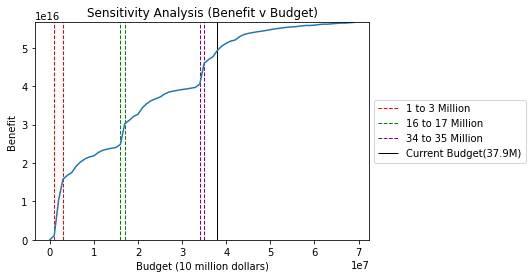

In [133]:
# plot the result from the result of the sensitivity analysis

plt.figure()  # all the plots will be in one figure.
plt.plot(list_objective_x, list_objective_y)
plt.xlabel('Budget (10 million dollars)')
plt.ylabel("Benefit")
plt.title("Sensitivity Analysis (Benefit v Budget)")
ymin, ymax = 0, max(list_objective_y)

# plot vertical line for particular budgets
plt.vlines(1000000, ymin, ymax,colors='red', ls='--',lw=1, label='1 to 3 Million')
plt.vlines(3000000, ymin, ymax,colors='red', ls='--',lw=1)
plt.vlines(16000000, ymin, ymax,colors='green', ls='--',lw=1, label='16 to 17 Million')
plt.vlines(17000000, ymin, ymax,colors='green', ls='--',lw=1)
plt.vlines(34000000, ymin, ymax,colors='purple', ls='--',lw=1, label='34 to 35 Million')
plt.vlines(35000000, ymin, ymax,colors='purple', ls='--',lw=1)
plt.vlines(37900000, ymin, ymax,colors='black',lw=1, label='Current Budget(37.9M)')
plt.ylim(ymin, ymax+1000000)

plt.legend(loc='center left', bbox_to_anchor=(1., .5))
plt.show()